In [ ]:
FIREWORKS_API_KEY = "use your api key"

In [ ]:
import os
import re
import json
import base64
from typing import Dict, Any, TypedDict

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.messages import HumanMessage, AIMessage


os.environ["OPENAI_API_BASE"] = "https://api.fireworks.ai/inference/v1/completions"
os.environ["OPENAI_API_KEY"] = FIREWORKS_API_KEY   

class LicenseData(BaseModel):
    Name: str
    Date_of_birth: str
    Address: str
    Date_of_expiry: str
    Date_of_issuance: str
    Class: str = Field(..., description="Class is usually a single letter like A or C")
    Sex: str = Field(
    ...,description="Sex is usally a single letter like M or F against Sex")
                
    Height: str = Field(
    ..., description="Height can be written againts HGT or height")
    Eyes: str
    Weight: str = Field(...,
    description="Weight is written againts WGT. If not present return None"
                )
    # Identification number appears after DL or DLN
    Document_identification_number: str = Field(...)

class PassportData(BaseModel):
    Name: str
    Date_of_birth: str
    Address: str
    Date_of_expiry: str
    Date_of_issuance: str

    # Passport number appears under Passport No
    Passport_number: str = Field(...)

# Using Fireworks endpoint for OpenAI apis
llm = ChatOpenAI(
    model="accounts/fireworks/models/deepseek-v3",
    base_url="https://api.fireworks.ai/inference/v1",
    temperature=0,
    max_tokens=4096
)

class DocumentState(TypedDict):
    document_image: str
    document_type: str
    extracted_data: Dict[str, Any]  # Ensure this is included

class ClassificationInput(TypedDict):
    document_image: str

class ClassificationOutput(TypedDict):
    document_image: str
    document_type: str

class ExtractionOutput(TypedDict):
    extracted_data: Dict[str, Any]

def process_classification(document_image):
    """Process an image to classify it as license or passport"""
    messages = [
        AIMessage(content="You are a bot that is good at analyzing document images."),
        HumanMessage(content=[
            {"type": "text", "text": "Is this document a license or a passport? Answer with only one word: 'license' or 'passport'."},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{document_image}#transform=inline"
                },
            },
        ])
    ]
    response = llm.invoke(messages)
    return response.content.lower().strip()

def process_license_extraction(document_image):
    """Extract data from a license document image"""
    messages = [
        AIMessage(content="You are an expert data extractor."),
        HumanMessage(content=[
            {"type": "text", "text": """
            Extract the following fields from this license document and output a JSON object that conforms to the given schema:
            
            Schema for License:
            {
              "Name": "string",
              "Date_of_birth": "string",
              "Address": "string",
              "Date_of_expiry": "string",
              "Date_of_issuance": "string",
              "Class": "string" //"Class is usually a single letter like A or C",
              "Sex": "string" //"Sex is usally a single letter like M or against Sex",
              "Height": "string" //"Height can be written againts HGT or height",
              "Eyes": "string,
              "Weight" : "string" //"Weight is written againts WGT. If not present return None",
              "Document_identification_number": "string"  // Appears after DL or DLN
            }
            
            Provide only the JSON output.
            """},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{document_image}#transform=inline"
                },
            },
        ])
    ]
    response = llm.invoke(messages)
    json_match = re.search(r'```json\s*([\s\S]*?)\s*```', response.content)
    if json_match:
        json_str = json_match.group(1)
    else:
        json_str = response.content
    
    try:
        return json.loads(json_str)
    except:
        return {"error": "Failed to parse JSON", "raw_response": response.content}

def process_passport_extraction(document_image):
    """Extract data from a passport document image"""
    messages = [
        AIMessage(content="You are an expert data extractor."),
        HumanMessage(content=[
            {"type": "text", "text": """
            Extract the following fields from this passport document and output a JSON object that conforms to the given schema:
            
            Schema for Passport:
            {
              "Name": "string",
              "Date_of_birth": "string",
              "Address": "string",
              "Date_of_expiry": "string",
              "Date_of_issuance": "string",
              "Passport_number": "string"  // Appears under Passport No
            }
            
            Provide only the JSON output.
            """},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{document_image}#transform=inline"
                },
            },
        ])
    ]
    response = llm.invoke(messages)
    
    json_match = re.search(r'```json\s*([\s\S]*?)\s*```', response.content)
    if json_match:
        json_str = json_match.group(1)
    else:
        json_str = response.content
    
    try:
        return json.loads(json_str)
    except:
        # If parsing fails, return a structured error
        return {"error": "Failed to parse JSON", "raw_response": response.content}



def classify(state: ClassificationInput) -> ClassificationOutput:
    document_image = state["document_image"]
    

    classification = process_classification(document_image)
    print("Classification complete:", classification)
    
    return {
        "document_image": document_image,
        "document_type": classification
    }

def extract_license(state: ClassificationOutput) -> ExtractionOutput:
    document_image = state["document_image"]
    
    extracted = process_license_extraction(document_image)
    return {
        "document_image": document_image,
        "document_type": state["document_type"],
        "extracted_data": extracted  # Ensure this is present
    }
   

def extract_passport(state: ClassificationOutput) -> ExtractionOutput:
    document_image = state["document_image"]
    
    extracted = process_passport_extraction(document_image)

    return {
        "document_image": document_image,
        "document_type": state["document_type"],
        "extracted_data": extracted  # Ensure this is present
    }

def route_extraction(state: ClassificationOutput) -> str:
    document_type = state["document_type"].lower().strip()
    if "license" in document_type:
        return "license"
    elif "passport" in document_type:
        return "passport"
    else:
        raise ValueError(f"Unsupported document type: {document_type}")

workflow = StateGraph(DocumentState)
workflow.add_node("classification", classify)
workflow.add_node("license", extract_license)
workflow.add_node("passport", extract_passport)

workflow.add_conditional_edges(
    "classification",
    route_extraction,
    {
        "license": "license",
        "passport": "passport"
    }
)

workflow.set_entry_point("classification")

app = workflow.compile()

def run_document_pipeline(document_image: str) -> dict:
    inputs = {"document_image": document_image}
    result = app.invoke(inputs)
    return result

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

if __name__ == "__main__":
    image_path = "Identity Documents/License-2.jpg"
    encode_image_64 = encode_image(image_path)

    result = run_document_pipeline(encode_image_64)
    print("Final Extracted Information:")
    print(result['extracted_data'])


Classification complete: license
Final Extracted Information:
{'Name': 'Janice Sample', 'Date_of_birth': '01/07/2005', 'Address': '123 MAIN STREET APT. 1 HARRISBURG, PA 17101-0000', 'Date_of_expiry': '01/08/2026', 'Date_of_issuance': '01/07/2022', 'Class': 'C', 'Sex': 'F', 'Height': '5\'-05"', 'Eyes': 'BLU', 'Weight': 'None', 'Document_identification_number': '99 999 999'}


In [9]:
def process_all_documents(folder_path: str) -> dict:

    supported_extensions = ('.jpg', '.jpeg', '.png')
    results = {}

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(supported_extensions):
            file_path = os.path.join(folder_path, file_name)
            encoded_image = encode_image(file_path)
            result = run_document_pipeline(encoded_image)
            results[file_name] = result
            print(f"Processed {file_name}")
    
    return results

# Example usage:
if __name__ == "__main__":
    folder = "Identity Documents"
    all_results = process_all_documents(folder)
    for file, data in all_results.items():
        print(f"\nResults for {file}:")
        print(data.get('extracted_data', data))


Classification complete: license
Processed License 1.png
Classification complete: license
Processed License-2.jpg
Classification complete: license
Processed License-3.jpeg
Classification complete: passport
Processed passport-1.jpeg
Classification complete: passport
Processed passport-2.jpg

Results for License 1.png:
{'Name': 'IMA CARDHOLDER', 'Date_of_birth': '08/31/1977', 'Address': '2570 24TH STREET, ANYTOWN, CA 95818', 'Date_of_expiry': '08/31/2014', 'Date_of_issuance': '08/31/2009', 'Class': 'C', 'Sex': 'F', 'Height': '5\'-05"', 'Eyes': 'BRN', 'Weight': '125 lb', 'Document_identification_number': '11234568'}

Results for License-2.jpg:
{'Name': 'Janice Sample', 'Date_of_birth': '01/07/2005', 'Address': '123 MAIN STREET APT. 1 HARRISBURG, PA 17101-0000', 'Date_of_expiry': '01/08/2026', 'Date_of_issuance': '01/07/2022', 'Class': 'C', 'Sex': 'F', 'Height': '5\'-05"', 'Eyes': 'BLU', 'Weight': 'None', 'Document_identification_number': '99 999 999'}

Results for License-3.jpeg:
{'Name':

### Explanation of agentic graph structure. 
### There are 3 Agents working.

* 1. Classification Agent : Agent classifies the document into 'license' or 'passport' based on the image.
* 2. License Agent : Agent specialized in extraction of license information with pydantic type validation
* 3. Passport Agent : Agent specialized in extraction of passport information with pydantic validation

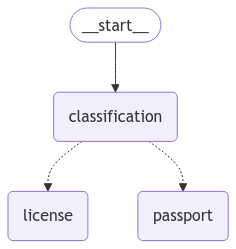

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)